# Requirements

In [2]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

In [4]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [5]:
from mnist1d_utils import *

# Dataset

In [6]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

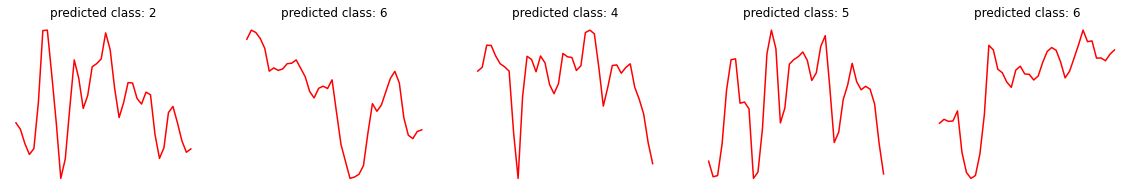

In [7]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

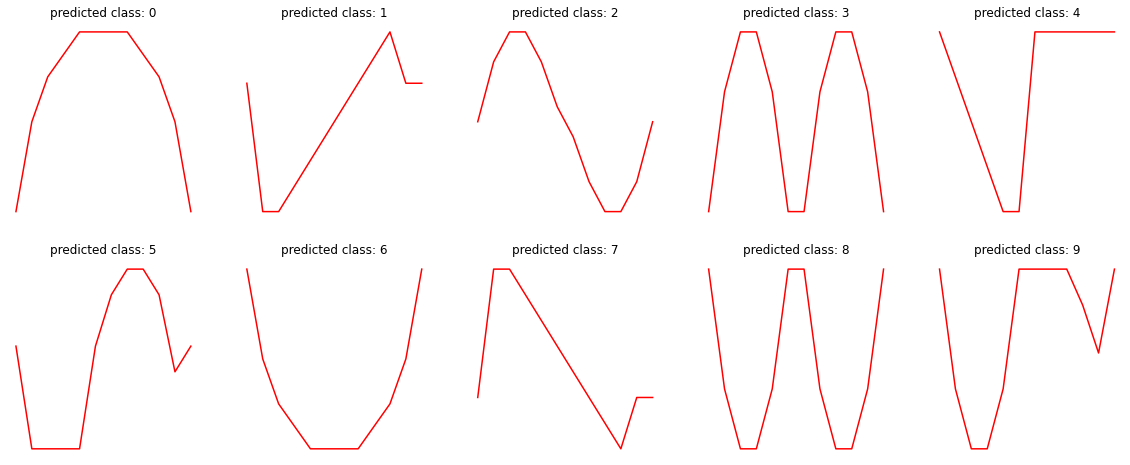

In [8]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [9]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [10]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here 
n_features = dataset['x'].shape[1]
n_classes = len(np.unique(dataset['y']))

model.add(Conv1D(25, 5, padding='same', activation='relu', 
                 kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_normal', 
                 input_shape=(n_features,1)))
model.add(Conv1D(25, 3, padding='same', activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(25, 3, padding='same', activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))
##

# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [11]:
##Task1-Question2
x_train = dataset['x']
y_train = dataset['y']
#x_train.reshape(-1, 1, 40)
#Your code 
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',  metrics=['accuracy'])
#history=model.fit(x_train, y_train, epochs=200, batch_size=32)
history=model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, epochs=200, verbose=True)
##

Epoch 1/200
113/113 [==============================] - 1s 4ms/step - loss: 2.2578 - accuracy: 0.2119 - val_loss: 1.9699 - val_accuracy: 0.2675
Epoch 2/200
113/113 [==============================] - 0s 3ms/step - loss: 1.7967 - accuracy: 0.3517 - val_loss: 1.6879 - val_accuracy: 0.3925
Epoch 3/200
113/113 [==============================] - 0s 3ms/step - loss: 1.5899 - accuracy: 0.4300 - val_loss: 1.5492 - val_accuracy: 0.3975
Epoch 4/200
113/113 [==============================] - 0s 3ms/step - loss: 1.4451 - accuracy: 0.4908 - val_loss: 1.4923 - val_accuracy: 0.4425
Epoch 5/200
113/113 [==============================] - 0s 2ms/step - loss: 1.3286 - accuracy: 0.5306 - val_loss: 1.3750 - val_accuracy: 0.5025
Epoch 6/200
113/113 [==============================] - 0s 3ms/step - loss: 1.2290 - accuracy: 0.5725 - val_loss: 1.2825 - val_accuracy: 0.5200
Epoch 7/200
113/113 [==============================] - 0s 3ms/step - loss: 1.1474 - accuracy: 0.6089 - val_loss: 1.2116 - val_accuracy: 0.5375

Epoch 58/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9847 - val_loss: 0.6865 - val_accuracy: 0.8150
Epoch 59/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1784 - accuracy: 0.9850 - val_loss: 0.6083 - val_accuracy: 0.8250
Epoch 60/200
113/113 [==============================] - 0s 3ms/step - loss: 0.1734 - accuracy: 0.9861 - val_loss: 0.5652 - val_accuracy: 0.8300
Epoch 61/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1741 - accuracy: 0.9872 - val_loss: 0.5899 - val_accuracy: 0.8425
Epoch 62/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1695 - accuracy: 0.9861 - val_loss: 0.5671 - val_accuracy: 0.8400
Epoch 63/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9864 - val_loss: 0.7162 - val_accuracy: 0.8200
Epoch 64/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.9872 - val_loss: 0.6355 - val_accuracy:

Epoch 115/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1151 - accuracy: 1.0000 - val_loss: 0.6465 - val_accuracy: 0.8325
Epoch 116/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1149 - accuracy: 1.0000 - val_loss: 0.6552 - val_accuracy: 0.8300
Epoch 117/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1150 - accuracy: 1.0000 - val_loss: 0.6583 - val_accuracy: 0.8475
Epoch 118/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1142 - accuracy: 1.0000 - val_loss: 0.6575 - val_accuracy: 0.8300
Epoch 119/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1139 - accuracy: 1.0000 - val_loss: 0.6573 - val_accuracy: 0.8400
Epoch 120/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1138 - accuracy: 1.0000 - val_loss: 0.6597 - val_accuracy: 0.8400
Epoch 121/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1131 - accuracy: 1.0000 - val_loss: 0.6783 - val_ac

113/113 [==============================] - 0s 2ms/step - loss: 0.1036 - accuracy: 1.0000 - val_loss: 0.6746 - val_accuracy: 0.8425
Epoch 172/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 1.0000 - val_loss: 0.6817 - val_accuracy: 0.8425
Epoch 173/200
113/113 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 1.0000 - val_loss: 0.6728 - val_accuracy: 0.8475
Epoch 174/200
113/113 [==============================] - 0s 3ms/step - loss: 0.1031 - accuracy: 1.0000 - val_loss: 0.6706 - val_accuracy: 0.8425
Epoch 175/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1030 - accuracy: 1.0000 - val_loss: 0.6817 - val_accuracy: 0.8425
Epoch 176/200
113/113 [==============================] - 0s 3ms/step - loss: 0.1028 - accuracy: 1.0000 - val_loss: 0.6781 - val_accuracy: 0.8400
Epoch 177/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 1.0000 - val_loss: 0.6764 - val_accuracy: 0.8400

# Plotting the training progress

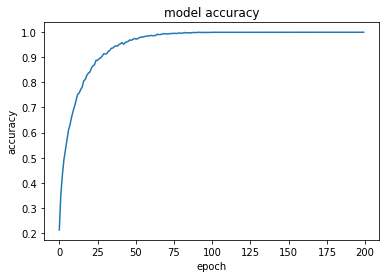

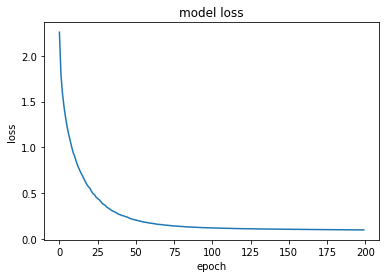

In [12]:
##Task1-Question3.a
#Plot for loss curve and for accuracy curve

#Accuracy Curve
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()
##

#Loss Curve
plt.plot(history.history['loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
##

In [13]:
##Task1-Question 3.b
#Overall classification accuracy on the test set

x_test = dataset['x_test']
y_test = dataset['y_test']
loss, acc = model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.5357 - accuracy: 0.8780


In [14]:
##Task1-Question 3.c 
#Class-wise classification accuracy for all classes

#Divide predicted results with test results for each class.
correct_response = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_pred = model.predict(x_test)
for i in range(len(y_test)):
    if np.argmax(y_pred[i]) == y_test[i]:
        correct_response[y_test[i]] += 1
    #else:
    #    print("At Index: ",str(i), "Predicted: ", str(np.argmax(y_pred[i])), "Correct: ", str(y_test[i]))

for i in range(10):
    print("Classification accuracy for {} is {}".format(i, 
                                                        correct_response[i]/np.count_nonzero(y_test == i)))

Classification accuracy for 0 is 0.9607843137254902
Classification accuracy for 1 is 0.8557692307692307
Classification accuracy for 2 is 0.8089887640449438
Classification accuracy for 3 is 0.9716981132075472
Classification accuracy for 4 is 0.8301886792452831
Classification accuracy for 5 is 0.8163265306122449
Classification accuracy for 6 is 0.9696969696969697
Classification accuracy for 7 is 0.8645833333333334
Classification accuracy for 8 is 0.9591836734693877
Classification accuracy for 9 is 0.7352941176470589


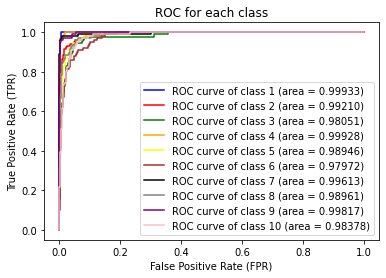

In [30]:
##Task1-Question 3.d
#Plot the classification ROC and AUC curves for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

sample_row = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_test_classes = np.array([])

for i in range(len(y_test)):
    if i==0:
        sample_row[y_test[i]] = 1
        y_test_classes = np.array([sample_row])
    else:
        sample_row[y_test[i]] = 1
        y_test_classes = np.vstack([y_test_classes, sample_row])
        
    sample_row = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

'''
#The following plotting code was adapted and changed from the following source:
/***************************************************************************************
*    Title: ROC Curve explained using a COVID-19 hypothetical example: Binary & Multi-Class Classification tutorial
*    Author: Serafeim Loukas
*    Date: Jun 10, 2020
*    Code version: N/A
*    Availability: https://towardsdatascience.com/roc-curve-explained-using-a-covid-19-hypothetical-example-binary-multi-class-classification-bab188ea869c
*
***************************************************************************************/
'''

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow', 'brown', 'black', 'grey', 'purple', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.5f})' ''.format(i+1, roc_auc[i]))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC for each class')
plt.legend(loc="lower right")
plt.show()

In [38]:
##Task1-Question 3.e

#Plot the normalized confusion matrix
from sklearn.metrics import confusion_matrix

predictions = [0]*len(y_pred)
for i in range(len(y_pred)):
    predictions[i] = np.argmax(y_pred[i])
predictions = np.array(predictions)

matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
matrix = matrix.astype('float')/matrix.sum(axis=1)[:,np.newaxis]
print(matrix)

[[0.96 0.   0.   0.   0.   0.   0.   0.04 0.   0.  ]
 [0.   0.86 0.04 0.   0.01 0.09 0.01 0.   0.   0.  ]
 [0.   0.03 0.81 0.01 0.   0.07 0.01 0.06 0.   0.01]
 [0.   0.   0.   0.97 0.   0.   0.   0.03 0.   0.  ]
 [0.01 0.   0.02 0.   0.83 0.04 0.01 0.   0.01 0.08]
 [0.01 0.05 0.07 0.   0.03 0.82 0.   0.01 0.   0.01]
 [0.01 0.   0.   0.   0.   0.02 0.97 0.   0.   0.  ]
 [0.01 0.01 0.05 0.03 0.   0.02 0.01 0.86 0.   0.  ]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.96 0.03]
 [0.   0.   0.03 0.   0.1  0.03 0.   0.   0.11 0.74]]


In [17]:
##Task1-Question 3.f

#Precision, Recall, and F-1 score on the test set

from sklearn.metrics import precision_score
precision = precision_score(y_test, predictions, labels=[1,2,3,4,5,6,7,8,9], average='micro')
print("The precision on the test set is " + str(precision))

from sklearn.metrics import recall_score
recall = recall_score(y_test, predictions, labels=[1,2,3,4,5,6,7,8,9], average='micro')
print("The recall on the test set is "+str(recall))

f_1 = (2 * precision * recall) / (precision + recall)
print("The F-1 score on the test set is "+str(f_1))

The precision on the test set is 0.8685968819599109
The recall on the test set is 0.8685968819599109
The F-1 score on the test set is 0.8685968819599109


In [ ]:
##Task1-Question 4

#Show some examples of success/failure cases of the model. Among which two classes misclassification happens the most?
#Provide your insights and support your answers with analytic reasons.

'''
During the computation of classification accuracy, it was observed that the 1D numbers 4 and 9 were often getting 
mixed up. Looking at their templates, it is easy to observe that 4 and 9 look very similar and it is not a surprise
that the model often mixes them up. With the addition of the noise, the model may be getting even more confused
about how to distinguish between the two numbers. The only difference between 4 and 9 templates is near the ends where
4 is flat while 9 shows a small dip.
'''


## Success cases of Model

Text(0.5, 1.0, 'Template for class: 0')

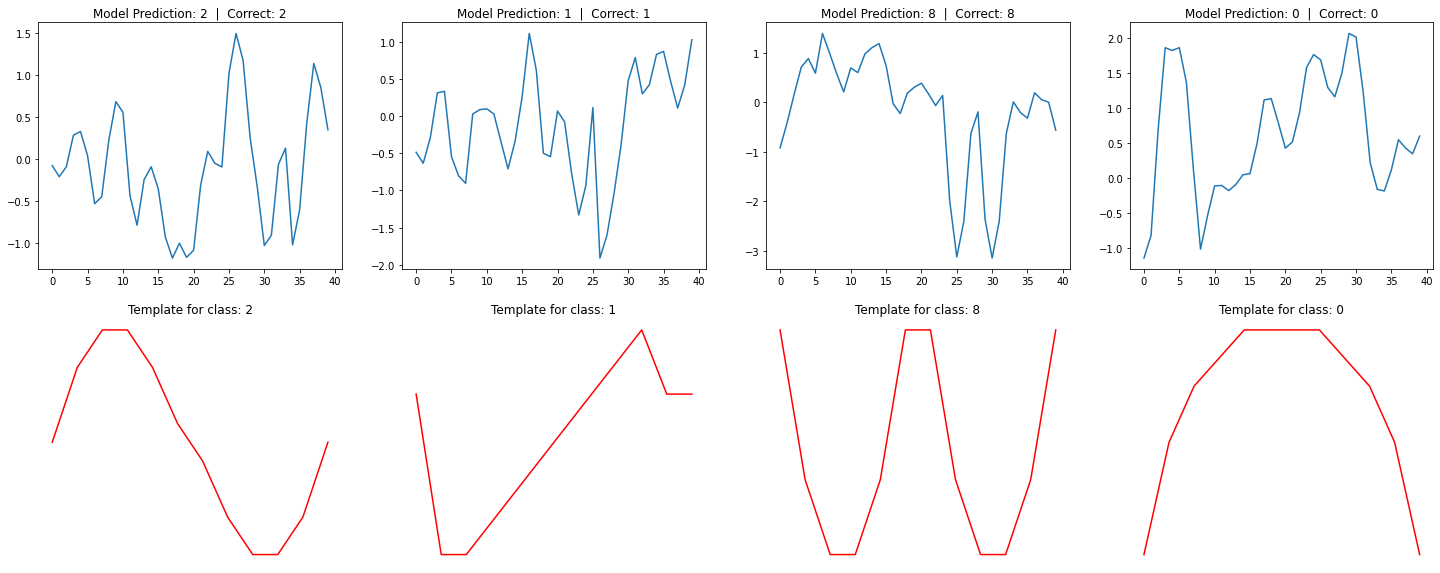

In [530]:
plt.figure(figsize=(25,10))

plt.subplot(2,4,1)
plt.plot(x_test[0])
plt.title('Model Prediction: '+str(np.argmax(y_pred[0]))+ "  |  Correct: "+str(y_test[0]))

plt.subplot(2,4,2)
plt.plot(x_test[6])
plt.title('Model Prediction: '+str(np.argmax(y_pred[6]))+ "  |  Correct: "+str(y_test[6]))

plt.subplot(2,4,3)
plt.plot(x_test[200])
plt.title('Model Prediction: '+str(np.argmax(y_pred[200]))+ "  |  Correct: "+str(y_test[200]))

plt.subplot(2,4,4)
plt.plot(x_test[302])
plt.title('Model Prediction: '+str(np.argmax(y_pred[302]))+ "  |  Correct: "+str(y_test[302]))

plt.subplot(2,4,5)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('Template for class: 2')

plt.subplot(2,4,6)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('Template for class: 1')

plt.subplot(2,4,7)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('Template for class: 8')

plt.subplot(2,4,8)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('Template for class: 0')

## Failure cases of the Model

Text(0.5, 1.0, 'Template for class: 9')

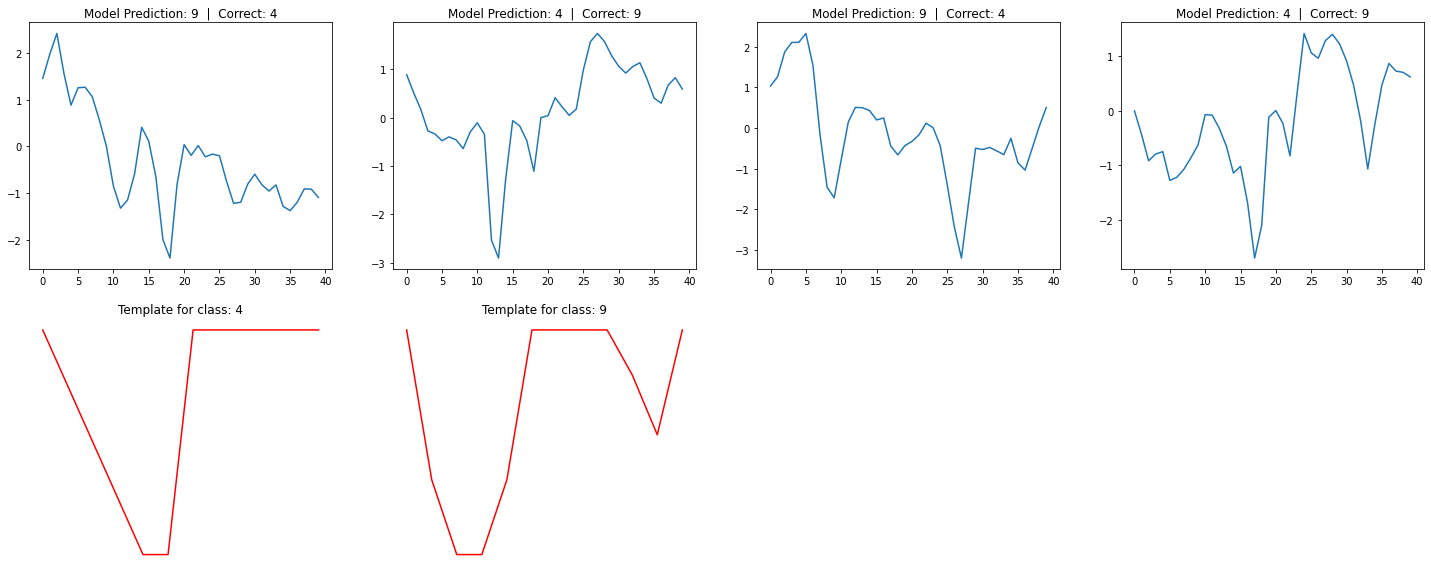

In [528]:
plt.figure(figsize=(25,10))

plt.subplot(2,4,1)
plt.plot(x_test[17])
plt.title('Model Prediction: '+str(np.argmax(y_pred[17]))+ "  |  Correct: "+str(y_test[17]))

plt.subplot(2,4,2)
plt.plot(x_test[20])
plt.title('Model Prediction: '+str(np.argmax(y_pred[20]))+ "  |  Correct: "+str(y_test[20]))

plt.subplot(2,4,3)
plt.plot(x_test[211])
plt.title('Model Prediction: '+str(np.argmax(y_pred[211]))+ "  |  Correct: "+str(y_test[211]))

plt.subplot(2,4,4)
plt.plot(x_test[239])
plt.title('Model Prediction: '+str(np.argmax(y_pred[239]))+ "  |  Correct: "+str(y_test[239]))

plt.subplot(2,4,5)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('Template for class: 4')

plt.subplot(2,4,6)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('Template for class: 9')

# Explanation

In [533]:
from xai_utils import *

Take a test sample

In [534]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [543]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 7
Predicted digit: 7
Confidence score for the correct label: 0.9992488


# RISE

In [625]:
def create_random_mask1(h=1, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):
    #assert H>h, 'Masks should be resized to higher dimensions.'
    assert W>w, 'Masks should be resized to higher dimensions.'
    # create random binary hxw mask
    mask=np.random.choice([0, 1], size=(h, w), p=[1-p_1, p_1])

    # upsample mask to (h+H,w+W)
    mask = Image.fromarray(mask*255.)
    mask = mask.resize((W + w, H + h), resample=resample)
    mask = np.array(mask)
    #print(mask.shape)
    
    # randomly crop mask to HxW
    w_crop = np.random.randint(0,w+1)
    h_crop = np.random.randint(0,h+1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]
    #print(h_crop, H + h_crop, w_crop, W + w_crop)
    
    #print(mask.shape)
    # normalize between 0 and 1
    if np.max(mask) == 0:
        #print(mask)
        return mask
    else:
        mask /= np.max(mask)
        return mask

def RISE1(img, model, class_index, N_MASKS=8000, H=224, W=224, C=3):
    #X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    X = np.zeros(shape=(N_MASKS, W), dtype=np.float32)
    #print(X.shape)
    #print(X[0])

    masks = np.zeros((N_MASKS,H,W), dtype=np.float32)
    #for i in tqdm(range(N_MASKS)):
    for i in range(N_MASKS):
        m =create_random_mask1(H=H, W=W)
        masks[i] = m
        x = img.copy()
        x *= m
        #print(x)
        #print(X.shape)
        X[i] = x
    #print(X)
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

#print(x_test[0:2])
explanation = RISE1(x_test[0:1], model, class_index=2, N_MASKS=4000, H=1, W=40, C=1)
explanation2 = RISE1(x_test[1:2], model, class_index=6, N_MASKS=4000, H=1, W=40, C=1)
explanation3 = RISE1(x_test[2:3], model, class_index=3, N_MASKS=4000, H=1, W=40, C=1)
explanation4 = RISE1(x_test[4:5], model, class_index=4, N_MASKS=4000, H=1, W=40, C=1)
explanation5 = RISE1(x_test[6:7], model, class_index=1, N_MASKS=4000, H=1, W=40, C=1)
explanation6 = RISE1(x_test[8:9], model, class_index=5, N_MASKS=4000, H=1, W=40, C=1)
explanation7 = RISE1(x_test[10:11], model, class_index=0, N_MASKS=4000, H=1, W=40, C=1)
explanation8 = RISE1(x_test[11:12], model, class_index=7, N_MASKS=4000, H=1, W=40, C=1)
explanation9 = RISE1(x_test[28:29], model, class_index=9, N_MASKS=4000, H=1, W=40, C=1)

## RISE 1D Explanation Map Class 0

Text(0.5, 1.0, 'Highlighted region (by the RISE)')

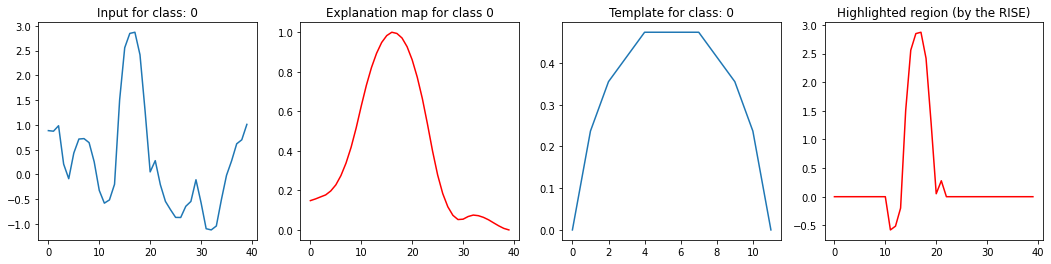

In [656]:
plt.figure(figsize=(18,4))

threshold = np.sort(explanation7[0,:])[-12]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][10])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][10]))

plt.subplot(1,4,2)
plt.plot(explanation7[0], 'r')
#plt.axis('off')
plt.title('Explanation map for class '+str(dataset['y_test'][10]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][0])
#plt.axis('off')
plt.title('Template for class: 0')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][10]*(explanation7>threshold)[0], 'r')
plt.title('Highlighted region (by the RISE)')

## RISE 1D Explanation Map Class 1


Text(0.5, 1.0, 'Highlighted region (by the RISE)')

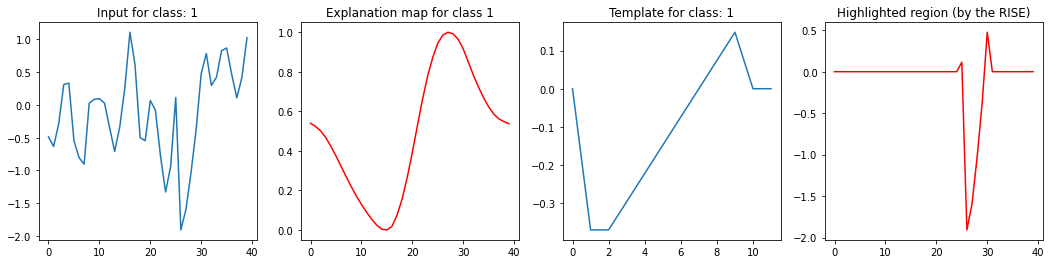

In [657]:
plt.figure(figsize=(18,4))

threshold = np.sort(explanation5[0,:])[-7]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][6])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][6]))

plt.subplot(1,4,2)
plt.plot(explanation5[0], 'r')
#plt.axis('off')
plt.title('Explanation map for class '+str(dataset['y_test'][6]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][1])
#plt.axis('off')
plt.title('Template for class: 1')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][6]*(explanation5>threshold)[0], 'r')
plt.title('Highlighted region (by the RISE)')

## RISE 1D Explanation Map Class 2

Text(0.5, 1.0, 'Highlighted region (by the RISE)')

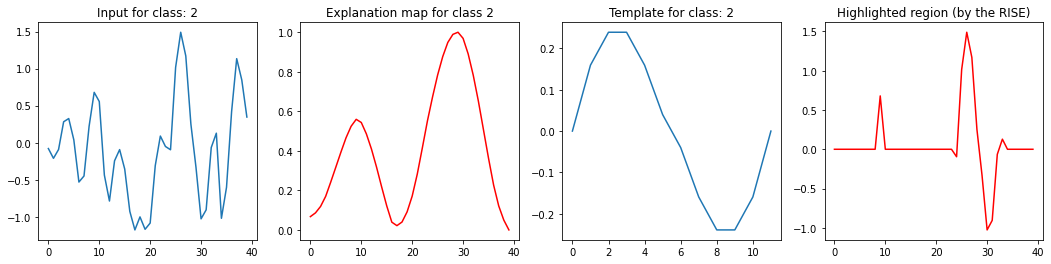

In [582]:
plt.figure(figsize=(18,4))

threshold = np.sort(explanation[0,:])[-12]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][0])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][0]))

plt.subplot(1,4,2)
plt.plot(explanation[0], 'r')
#plt.axis('off')
plt.title('Explanation map for class '+str(dataset['y_test'][0]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][2])
#plt.axis('off')
plt.title('Template for class: 2')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][0]*(explanation>threshold)[0], 'r')
plt.title('Highlighted region (by the RISE)')

## RISE 1D Explanation Map Class 3

Text(0.5, 1.0, 'Highlighted region (by the RISE)')

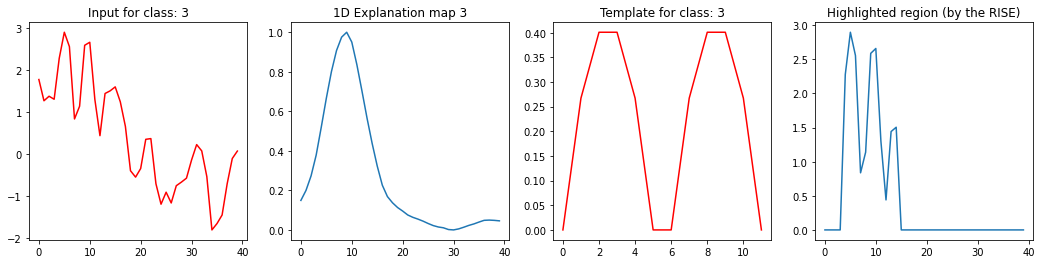

In [658]:
plt.figure(figsize=(18,4))
threshold = np.sort(explanation3[0,:])[-12]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][2], 'r')
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][2]))

plt.subplot(1,4,2)
plt.plot(explanation3[0])
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][2]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][3], 'r')
#plt.axis('off')
plt.title('Template for class: 3')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][2]*(explanation3>threshold)[0])
plt.title('Highlighted region (by the RISE)')

## RISE 1D Explanation Map Class 4

Text(0.5, 1.0, 'Highlighted region (by the RISE)')

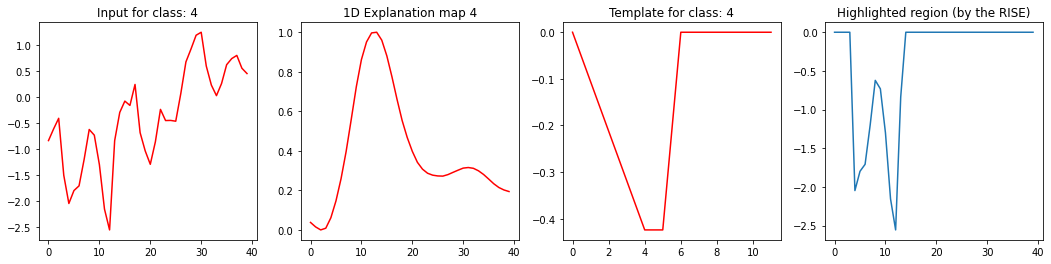

In [659]:
plt.figure(figsize=(18,4))
threshold = np.sort(explanation4[0,:])[-12]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][4], 'r')
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][4]))

plt.subplot(1,4,2)
plt.plot(explanation4[0], 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][4]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][4], 'r')
#plt.axis('off')
plt.title('Template for class: 4')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][4]*(explanation3>threshold)[0])
plt.title('Highlighted region (by the RISE)')

## RISE 1D Explanation Map Class 5

Text(0.5, 1.0, 'Highlighted region (by the RISE)')

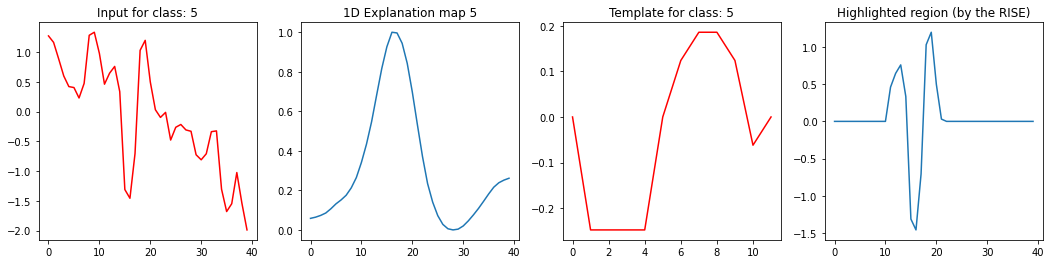

In [739]:
plt.figure(figsize=(18,4))
threshold = np.sort(explanation6[0,:])[-12]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][8], 'r')
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][8]))

plt.subplot(1,4,2)
plt.plot(explanation6[0])
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][8]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][5], 'r')
#plt.axis('off')
plt.title('Template for class: 5')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][8]*(explanation6>threshold)[0])
plt.title('Highlighted region (by the RISE)')

## RISE 1D Explanation Map Class 6

Text(0.5, 1.0, 'Highlighted region (by the RISE)')

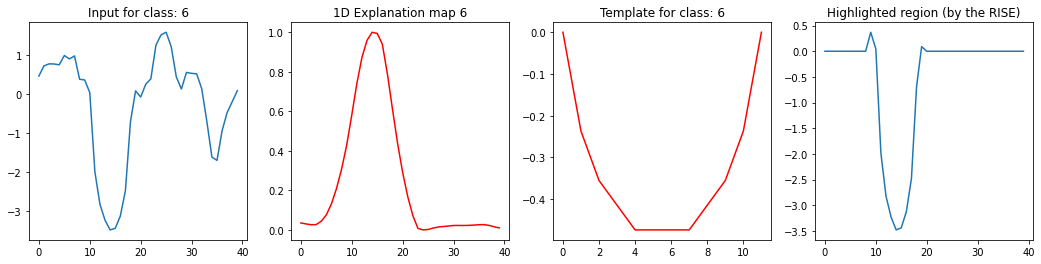

In [661]:
plt.figure(figsize=(18,4))
threshold = np.sort(explanation2[0,:])[-12]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][1])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][1]))

plt.subplot(1,4,2)
plt.plot(explanation2[0], 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][1]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][6], 'r')
#plt.axis('off')
plt.title('Template for class: 6')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][1]*(explanation2>threshold)[0])
plt.title('Highlighted region (by the RISE)')

# LIME for class 0

Correct Answer is: 0
Predicted Answer is: 0


Text(0.5, 1.0, 'Highlighted region (by the LIME)')

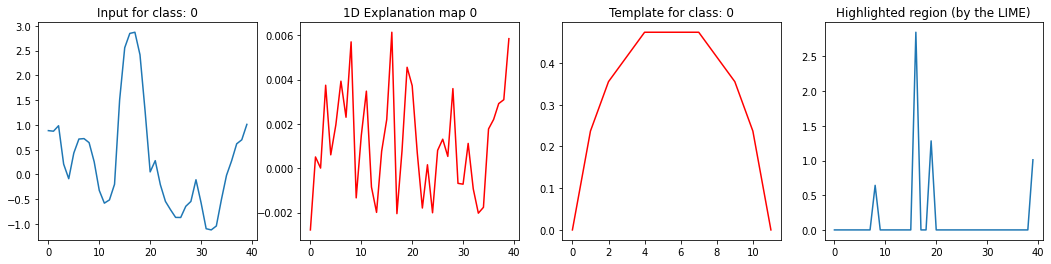

In [746]:
from lime import lime_tabular
feature_target = ['0', '1','2','3','4','5','6','7','8','9']

explain_model = lime_tabular.LimeTabularExplainer(dataset['x'], 
                                                  class_names=feature_target,discretize_continuous=True)

j=10
explanation = explain_model.explain_instance(x_test[j], model.predict, num_features=40, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[j]))
print("Predicted Answer is: " + str(np.argmax(y_pred[j])))

results = list(explanation.as_map().values())[0]
results.sort()
x_axis = []
lime_map = []
for i in range(len(results)):
    x_axis.append(results[i][0])
    lime_map.append(results[i][1])

plt.figure(figsize=(18,4))
threshold = np.sort(lime_map)[-5]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][j])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][j]))

plt.subplot(1,4,2)
plt.plot(lime_map, 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][j]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][0], 'r')
#plt.axis('off')
plt.title('Template for class: 0')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][j]*(lime_map>threshold))
plt.title('Highlighted region (by the LIME)')

# LIME for class 1

Correct Answer is: 1
Predicted Answer is: 1


Text(0.5, 1.0, 'Highlighted region (by the LIME)')

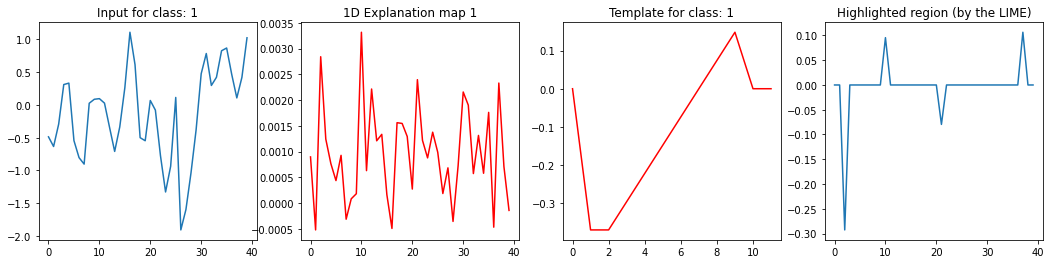

In [745]:
from lime import lime_tabular
feature_target = ['0', '1','2','3','4','5','6','7','8','9']

explain_model = lime_tabular.LimeTabularExplainer(dataset['x'], 
                                                  class_names=feature_target,discretize_continuous=True)

j=6
explanation = explain_model.explain_instance(x_test[j], model.predict, num_features=40, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[j]))
print("Predicted Answer is: " + str(np.argmax(y_pred[j])))

results = list(explanation.as_map().values())[0]
results.sort()
x_axis = []
lime_map = []
for i in range(len(results)):
    x_axis.append(results[i][0])
    lime_map.append(results[i][1])

plt.figure(figsize=(18,4))
threshold = np.sort(lime_map)[-5]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][j])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][j]))

plt.subplot(1,4,2)
plt.plot(lime_map, 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][j]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][1], 'r')
#plt.axis('off')
plt.title('Template for class: 1')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][j]*(lime_map>threshold))
plt.title('Highlighted region (by the LIME)')

# LIME for class 2

Correct Answer is: 2
Predicted Answer is: 2


Text(0.5, 1.0, 'Highlighted region (by the LIME)')

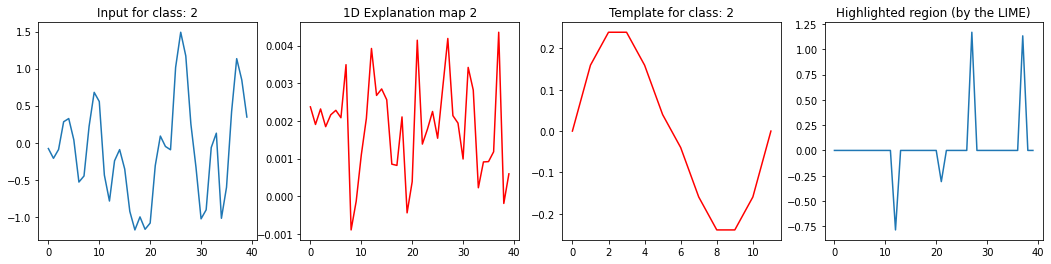

In [744]:
from lime import lime_tabular
feature_target = ['0', '1','2','3','4','5','6','7','8','9']

explain_model = lime_tabular.LimeTabularExplainer(dataset['x'], 
                                                  class_names=feature_target,discretize_continuous=True)

j=0
explanation = explain_model.explain_instance(x_test[j], model.predict, num_features=40, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[j]))
print("Predicted Answer is: " + str(np.argmax(y_pred[j])))

results = list(explanation.as_map().values())[0]
results.sort()
x_axis = []
lime_map = []
for i in range(len(results)):
    x_axis.append(results[i][0])
    lime_map.append(results[i][1])

plt.figure(figsize=(18,4))
threshold = np.sort(lime_map)[-5]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][j])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][j]))

plt.subplot(1,4,2)
plt.plot(lime_map, 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][j]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][2], 'r')
#plt.axis('off')
plt.title('Template for class: 2')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][j]*(lime_map>threshold))
plt.title('Highlighted region (by the LIME)')

# LIME for class 3

Correct Answer is: 3
Predicted Answer is: 3


Text(0.5, 1.0, 'Highlighted region (by the LIME)')

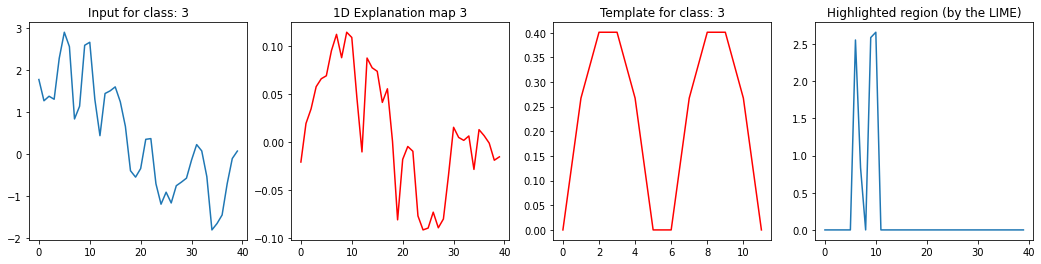

In [743]:
from lime import lime_tabular
feature_target = ['0', '1','2','3','4','5','6','7','8','9']

explain_model = lime_tabular.LimeTabularExplainer(dataset['x'], 
                                                  class_names=feature_target,discretize_continuous=True)

j=2
explanation = explain_model.explain_instance(x_test[j], model.predict, num_features=40, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[j]))
print("Predicted Answer is: " + str(np.argmax(y_pred[j])))

results = list(explanation.as_map().values())[0]
results.sort()
x_axis = []
lime_map = []
for i in range(len(results)):
    x_axis.append(results[i][0])
    lime_map.append(results[i][1])

plt.figure(figsize=(18,4))
threshold = np.sort(lime_map)[-5]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][j])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][j]))

plt.subplot(1,4,2)
plt.plot(lime_map, 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][j]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][3], 'r')
#plt.axis('off')
plt.title('Template for class: 3')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][j]*(lime_map>threshold))
plt.title('Highlighted region (by the LIME)')

# LIME for class 4

Correct Answer is: 4
Predicted Answer is: 4


Text(0.5, 1.0, 'Highlighted region (by the LIME)')

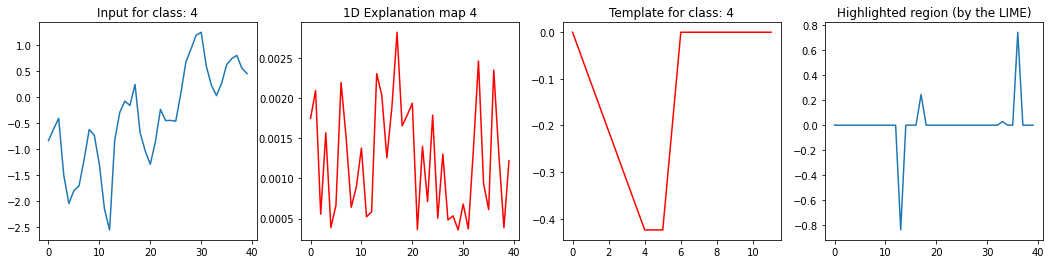

In [742]:
from lime import lime_tabular
feature_target = ['0', '1','2','3','4','5','6','7','8','9']

explain_model = lime_tabular.LimeTabularExplainer(dataset['x'], 
                                                  class_names=feature_target,discretize_continuous=True)

j=4
explanation = explain_model.explain_instance(x_test[j], model.predict, num_features=40, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[j]))
print("Predicted Answer is: " + str(np.argmax(y_pred[j])))

results = list(explanation.as_map().values())[0]
results.sort()
x_axis = []
lime_map = []
for i in range(len(results)):
    x_axis.append(results[i][0])
    lime_map.append(results[i][1])

plt.figure(figsize=(18,4))
threshold = np.sort(lime_map)[-5]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][j])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][j]))

plt.subplot(1,4,2)
plt.plot(lime_map, 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][j]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][4], 'r')
#plt.axis('off')
plt.title('Template for class: 4')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][j]*(lime_map>threshold))
plt.title('Highlighted region (by the LIME)')

# LIME for class 5

Correct Answer is: 5
Predicted Answer is: 5


Text(0.5, 1.0, 'Highlighted region (by the LIME)')

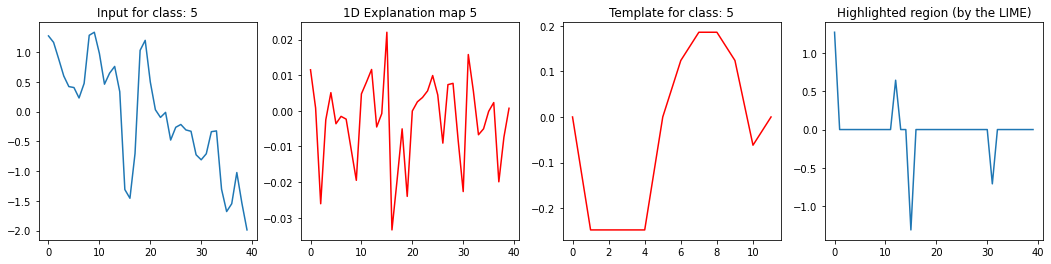

In [740]:
from lime import lime_tabular
feature_target = ['0', '1','2','3','4','5','6','7','8','9']

explain_model = lime_tabular.LimeTabularExplainer(dataset['x'], 
                                                  class_names=feature_target,discretize_continuous=True)

j=8
explanation = explain_model.explain_instance(x_test[j], model.predict, num_features=40, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[j]))
print("Predicted Answer is: " + str(np.argmax(y_pred[j])))

results = list(explanation.as_map().values())[0]
results.sort()
x_axis = []
lime_map = []
for i in range(len(results)):
    x_axis.append(results[i][0])
    lime_map.append(results[i][1])

plt.figure(figsize=(18,4))
threshold = np.sort(lime_map)[-5]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][j])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][j]))

plt.subplot(1,4,2)
plt.plot(lime_map, 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][j]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][5], 'r')
#plt.axis('off')
plt.title('Template for class: 5')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][j]*(lime_map>threshold))
plt.title('Highlighted region (by the LIME)')

# LIME for class 6

Correct Answer is: 6
Predicted Answer is: 6


Text(0.5, 1.0, 'Highlighted region (by the LIME)')

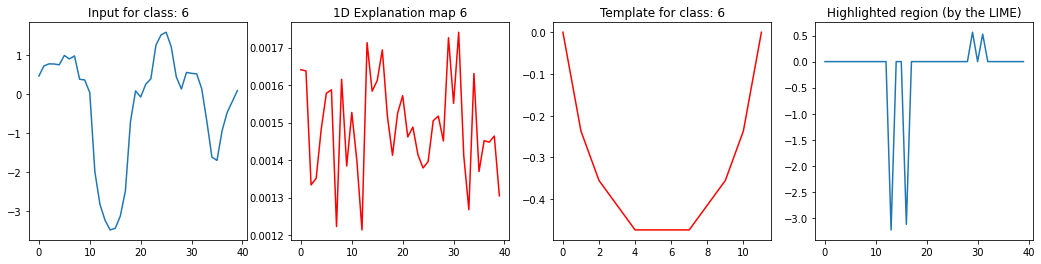

In [741]:
from lime import lime_tabular
feature_target = ['0', '1','2','3','4','5','6','7','8','9']

explain_model = lime_tabular.LimeTabularExplainer(dataset['x'], 
                                                  class_names=feature_target,discretize_continuous=True)

i=1
explanation = explain_model.explain_instance(x_test[i], model.predict, num_features=40, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[i]))
print("Predicted Answer is: " + str(np.argmax(y_pred[i])))

results = list(explanation.as_map().values())[0]
results.sort()
x_axis = []
lime_map_6 = []
for i in range(len(results)):
    x_axis.append(results[i][0])
    lime_map_6.append(results[i][1])

plt.figure(figsize=(18,4))
threshold = np.sort(lime_map_6)[-5]

plt.subplot(1,4,1)
plt.plot(dataset['x_test'][1])
#plt.axis('off')
plt.title('Input for class: '+str(dataset['y_test'][1]))

plt.subplot(1,4,2)
plt.plot(lime_map_6, 'r')
#plt.axis('off')
plt.title('1D Explanation map '+str(dataset['y_test'][1]))

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][6], 'r')
#plt.axis('off')
plt.title('Template for class: 6')

plt.subplot(1,4,4)
plt.plot(dataset['x_test'][1]*(lime_map_6>threshold))
plt.title('Highlighted region (by the LIME)')


In [655]:
i=2
explanation = explain_model.explain_instance(x_test[i], model.predict, num_features=5, 
                                             top_labels=1)
print("Correct Answer is: " + str(y_test[i]))
explanation.show_in_notebook()

Correct Answer is: 3


## Quantitative evaluation

In [747]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

## Drop and Increase Rate with RISE

In [ ]:
%%time
test_generator.reset()
drop_total_RISE = 0
increase_total_RISE = 0
for i in range(16):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    print("Working on batch ", str(i))
    
    for j in range(len(image_batch)):
        explanation_map_RISE = RISE(image_batch[j], model, class_index=np.argmax(prediction[index]),N_MASKS=100)
        explanation_map_RISE -= explanation_map_RISE.min()
        explanation_map_RISE /= explanation_map_RISE.max()+10e-30
        
        drop, increase, ori_pred, exp_pred = calculate_drop_increase(image_batch[j:j+1], model, explanation_map_RISE, 
                                class_index=np.argmax(prediction[index]), frac=0.9)
        drop_total_RISE+=drop
        increase_total_RISE+=increase
        #print("Original prediction is ",str(ori_pred), "Ex_prediction is ", str(exp_pred))

In [189]:
drop_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0]
drop_rate /= 1000

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

In [190]:
# mlp for binary classification
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
df = read_csv(path, header=None)
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]
# ensure all data are floating point values
X = X.astype('float32')
# encode strings to integer
print(y)
y = LabelEncoder().fit_transform(y)
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]
print("n_features is "+str(n_features))
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
# evaluate the model



URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

In [45]:
print(y_train)

[1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1
 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 0 0 0 1]


In [40]:
print(X_train.shape[1])
print(X_train)

34
[[ 1.0000e+00  0.0000e+00  1.0000e+00 ...  1.0000e+00  1.0000e+00
   1.0000e+00]
 [ 1.0000e+00  0.0000e+00  2.3370e-02 ...  0.0000e+00 -3.9000e-04
   1.2011e-01]
 [ 0.0000e+00  0.0000e+00  1.0000e+00 ... -1.0000e+00 -1.0000e+00
   1.0000e+00]
 ...
 [ 1.0000e+00  0.0000e+00  8.9706e-01 ... -5.0735e-01 -2.8676e-01
  -5.6618e-01]
 [ 1.0000e+00  0.0000e+00  1.0000e+00 ... -1.3722e-01  9.6523e-01
  -1.1717e-01]
 [ 1.0000e+00  0.0000e+00  1.0000e+00 ... -6.2880e-02 -1.3738e-01
  -2.4470e-02]]


In [49]:
print(dataset['x'].shape[1])
print(len(dataset['x']))

40
4000


In [48]:
print(dataset['y'])


[2 6 4 ... 5 4 8]
